# Benchmark des algorithmes de recommendation v2
---

Dans ce second **Benchmark** on s'intéressera aux modèles suivants :
- Démonstration et utilité des règles d'association
- Segmentation client/produit par l'algorithme KMeans
- 

*Le code source peut être trouvé dans le dossier src*

Ce notebook élabore différents méthodes permettant de palier au problème de **cold-start** et ainsi de proposer des recommendations aux nouveaux utilisateurs.               
Dans une optique d'optimisation, des méthodes *exploit/explore* type **multi-armed bandit** peuvent être utilisées afin de diversifier les recommendations proposées

## Règles d'association : Algorithme apriori

L'algorithme apriori est un algorithme de ARM (Association Rule Mining) qui permet de réaliser des recommendations par *session*.

On déclare 3 règles principales :
+ Support(item) = #Transactions(item) / #Transactions
+ Confidence(itemA -> itemB) = #Transactions(A & B) / #Transactions(A)
+ Lift(itemA -> itemB) = Confidence(A -> B)/ Support(B)                                                      

On en déduit les règles d'association :
+ Lift > 1 -> grande chance d'acheter les 2 items ensemble
+ Lift = 1 -> pas d'association 
+ Lift < 1 -> ne sont pas achetés ensemble généralement

Algorithme :
+ Définir un support/confidence minimum.
+ Séparer les données de support suffisant.
+ Choisir toutes les règles du subset avec une confidence suffisante.
+ Trier par ordre décroissant de Lift.


### Démonstration de l'algorithme

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from apyori import apriori

In [66]:
data = pd.read_csv('../Datasets/store_data.csv', header=None)
data.shape

(7501, 20)

In [67]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
records = data.astype(str).values.tolist()

In [69]:
# Pour avoir au moins 2 produits par règle
min_length = 3
# Support minimum : min(produit acheté par jour * 7) / nombre de transactions par semaine
min_support = (6*7) / len(records)
# Confidence minimum de 20%
min_confidence = 0.2

association_rules = apriori(records, min_length=min_length, min_support=min_support, min_confidence=min_confidence, min_lift=3)

In [70]:
association_results = list(association_rules)

In [71]:
association_results[0]

RelationRecord(items=frozenset({'escalope', 'mushroom cream sauce'}), support=0.005732568990801226, ordered_statistics=[OrderedStatistic(items_base=frozenset({'mushroom cream sauce'}), items_add=frozenset({'escalope'}), confidence=0.3006993006993007, lift=3.790832696715049)])

On montre ici qu'il y a 3.79 fois plus de chances (lift) qu'une escalope soit achetée avec de la crème de champignons que sans.                         

On peut ainsi implémenter un simple système de recommendation du type *Fréquemment acheté avec..*                               
De plus l'algorithme scale assez bien pour de larges datasets.             


## KMeans User Segmentation

In [118]:
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [119]:
user_data = pd.read_csv('../Datasets/lastfm-dataset-360K/usersha1-profile.tsv', header=None, names=['userID', 'gender', 'age', 'country', 'signup'], sep='\t', engine='python')
user_data.shape

(359347, 5)

In [120]:
user_data = user_data.query('10 < age < 100')

In [121]:
user_data.head()

,userID,gender,age,country,signup
0,00000c289a1829a808ac09c00daf10bc3c4e223b,f,22.0,Germany,"Feb 1, 2007"
3,000063d3fe1cf2ba248b9e3c3f0334845a27a6bf,m,19.0,Mexico,"Apr 28, 2008"
4,00007a47085b9aab8af55f52ec8846ac479ac4fe,m,28.0,United States,"Jan 27, 2006"
5,0000c176103e538d5c9828e695fed4f7ae42dd01,m,20.0,United Kingdom,"Jan 14, 2006"
6,0000ee7dd906373efa37f4e1185bfe1e3f8695ae,m,17.0,Finland,"Nov 17, 2007"


In [122]:
user_data.drop('userID', axis=1, inplace=True)
user_data.drop('signup', axis=1, inplace=True)
user_data.head()

,gender,age,country
0,f,22.0,Germany
3,m,19.0,Mexico
4,m,28.0,United States
5,m,20.0,United Kingdom
6,m,17.0,Finland


In [123]:
user_data.dropna(inplace=True)
user_data.shape

(265558, 3)

In [124]:
user_data.gender = user_data.gender.astype('category').cat.codes
user_data.country = user_data.country.astype('category').cat.codes
user_data = user_data.query('10 < age < 100')

In [125]:
scaler = MinMaxScaler()
user_data = pd.DataFrame(scaler.fit_transform(user_data), columns=["gender", "age", "country"])

In [126]:
# Ready for clustering
user_data.head()

,gender,age,country
0,0.0,0.125000,0.333333
1,1.0,0.090909,0.573840
2,1.0,0.193182,0.945148
3,1.0,0.102273,0.940928
4,1.0,0.068182,0.299578


In [131]:
# Perform KMeans clustering
# MiniBatchKMeans is faster for larger datasets 
kmeans = KMeans(n_clusters=7, random_state=42).fit(user_data)


In [132]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

colors = ['navy', 'turquoise', 'darkorange']

fig = plt.figure(figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

ax.scatter(user_data.gender,user_data.age, user_data.country, c=labels.astype(np.float), edgecolor='k')
            
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('gender')
ax.set_ylabel('age')
ax.set_zlabel('country')
ax.set_title('KMeans User Segmentation')
ax.dist = 12

ax.legend()

## KMeans Product Segmentation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

In [2]:
df_ratings = pd.read_csv('../Datasets/MovieTweetings/ratings.dat', sep='::', engine='python', names=['user_id', 'movie_id', 'rating', 'timestamp'])
df_ratings.head()

,user_id,movie_id,rating,timestamp
0,1,111161,10,1373234211
1,1,117060,7,1373415231
2,1,120755,6,1373424360
3,1,317919,6,1373495763
4,1,454876,10,1373621125


In [3]:
df_movies = pd.read_csv('../Datasets/MovieTweetings/movies.dat', sep='::', engine='python', names=['movie_id', 'title', 'genres'])
df_movies.head()

,movie_id,title,genres
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,10,La sortie des usines LumiÃ¨re (1895),Documentary|Short
2,12,The Arrival of a Train (1896),Documentary|Short
3,25,The Oxford and Cambridge University Boat Race ...,NaN
4,91,Le manoir du diable (1896),Short|Horror


In [4]:
print(f'Ce dataset contient {len(df_ratings)} notes pour {len(df_movies)} films.')

Ce dataset contient 392949 notes pour 34797 films.


Horror vs Adventure

In [8]:
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    movies = movies.dropna()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movie_id'].isin(genre_movies['movie_id'])].loc[:, ['user_id', 'rating']].groupby(['user_id'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings

In [9]:
# Calcul de la note moyenne pour chaque utilisateur donnée aux films d'horreur et d'aventure
genre_ratings = get_genre_ratings(df_ratings, df_movies, ['Horror', 'Adventure'], ['avg_horror_rating', 'avg_adventure_rating'])

In [13]:
genre_ratings.head()

,avg_horror_rating,avg_adventure_rating
1,7.0,7.44
2,8.0,7.38
4,NaN,7.00
5,NaN,9.00
6,NaN,5.00


On s'intéressera qu'aux utilisateurs aimant les films d'aventure ou les films d'horreur

In [22]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_horror_rating'] < score_limit_1 - 0.5) & (genre_ratings['avg_adventure_rating'] > score_limit_2)) | ((genre_ratings['avg_adventure_rating'] < score_limit_1) & (genre_ratings['avg_horror_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset.rename(columns={'index': 'user_id'})

In [23]:
biased_dataset = bias_genre_rating_dataset(genre_ratings, 6.4, 5.0)

In [24]:
print(f'Nombre d\'utilisateurs : {len(biased_dataset)}')
biased_dataset.head()

Nombre d'utilisateurs : 302


,user_id,avg_horror_rating,avg_adventure_rating
0,34,5.00,7.00
1,95,6.00,6.00
2,121,6.75,6.07
3,124,5.71,5.00
4,162,5.06,6.58


In [25]:
biased_dataset.isna().sum()

user_id                 0
avg_horror_rating       0
avg_adventure_rating    0
dtype: int64

In [32]:
def draw_scatterplot(x_data, x_label, y_data, y_label):
    """
    Helper function to draw scatterplots
    """
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

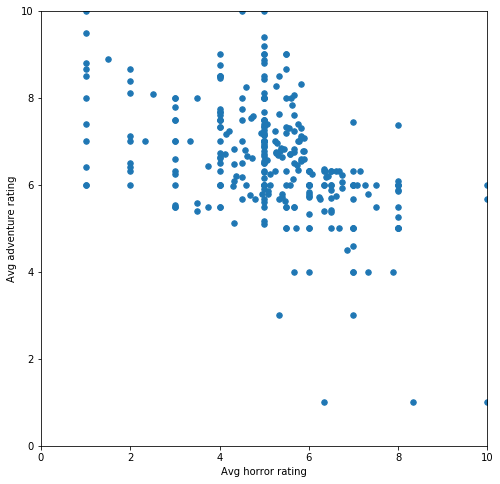

In [33]:
draw_scatterplot(biased_dataset['avg_horror_rating'],'Avg horror rating', biased_dataset['avg_adventure_rating'], 'Avg adventure rating')

Utilisation de KMeans pour identifier des segments utilisateurs

In [34]:
X = biased_dataset[['avg_horror_rating', 'avg_adventure_rating']].values

In [35]:
from sklearn.cluster import KMeans

In [36]:
k_means = KMeans(n_clusters=2)

predictions = k_means.fit_predict(X)

def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    ax.set_xlabel('Avg horror rating')
    ax.set_ylabel('Avg adventure rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_horror_rating'], clustered['avg_adventure_rating'], c=clustered['group'], s=20, cmap=cmap)

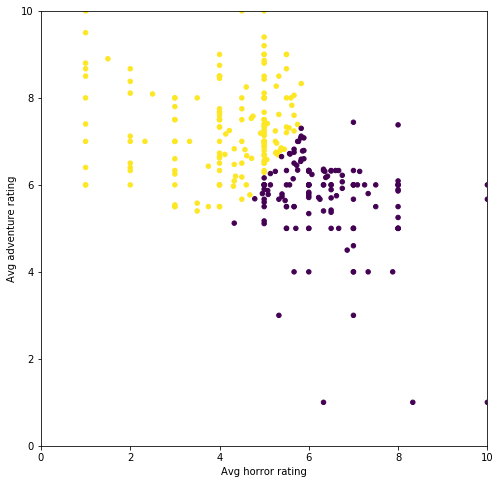

In [38]:
draw_clusters(biased_dataset, predictions)

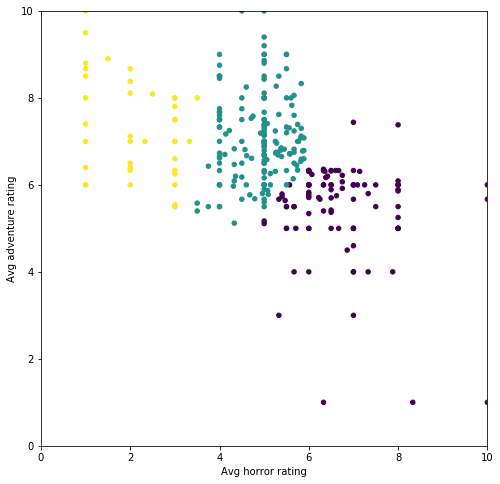

In [40]:
k_means_2 = KMeans(n_clusters=3)

predictions_2 = k_means_2.fit_predict(X)

draw_clusters(biased_dataset, predictions_2)

+ Les gens qui aiment l'aventure sont dans le groupe jaune
+ Les gens qui aiment l'aventure et moyennement l'horreur dans le groupe vert
+ Les gens qui aiment l'horreur et moyennement voir pas du tout l'aventure sont dans le groupe violet

Plus on rajoute de clusters, plus les segments identifiés sont proches et précis                                        

On procède ensuite à la méthode *du coude* afin de trouver le meilleur nombre de clusters K.

C:\Users\Lenovo\Anaconda3\envs\reco\lib\site-packages\ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (250) found smaller than n_clusters (252). Possibly due to duplicate points in X.
  
C:\Users\Lenovo\Anaconda3\envs\reco\lib\site-packages\ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (250) found smaller than n_clusters (257). Possibly due to duplicate points in X.
  
C:\Users\Lenovo\Anaconda3\envs\reco\lib\site-packages\ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (250) found smaller than n_clusters (262). Possibly due to duplicate points in X.
  
C:\Users\Lenovo\Anaconda3\envs\reco\lib\site-packages\ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (250) found smaller than n_clusters (267). Possibly due to duplicate points in X.
  
C:\Users\Lenovo\Anaconda3\envs\reco\lib\site-packages\ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (250) found smaller than 

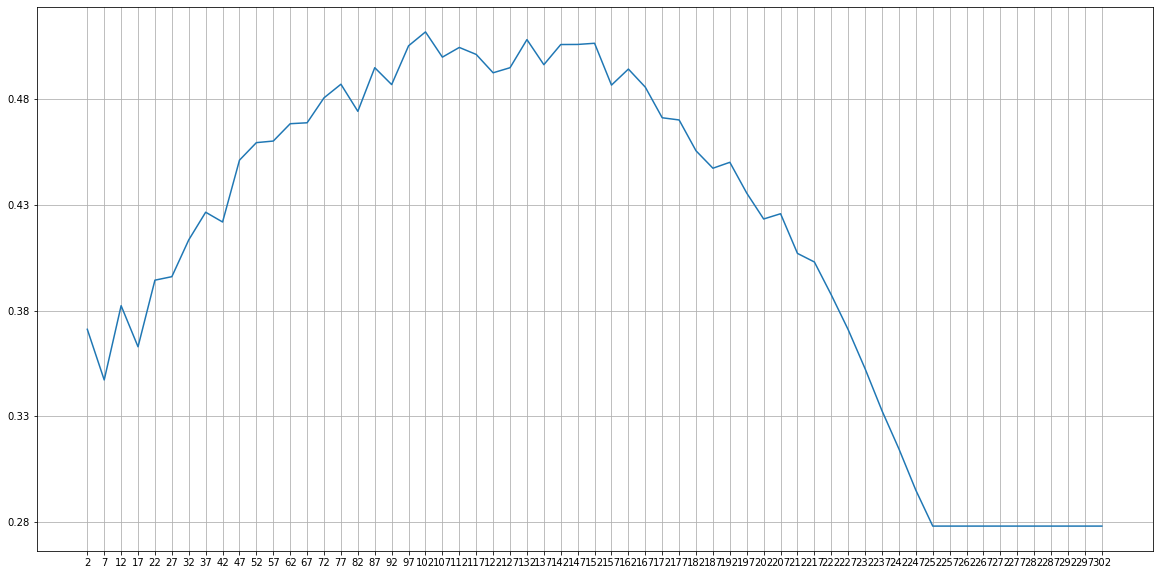

In [42]:

# df = biased_dataset[['avg_horror_rating','avg_adventure_rating']]

possible_k_values = range(2, len(X)+1, 5)

def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    # cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')

yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

12 Clusters semble être un bon choix ici donnant un score de 0.38 et étant cohérent avec le sujet, plus de clusters manquerait d'interprétabilité

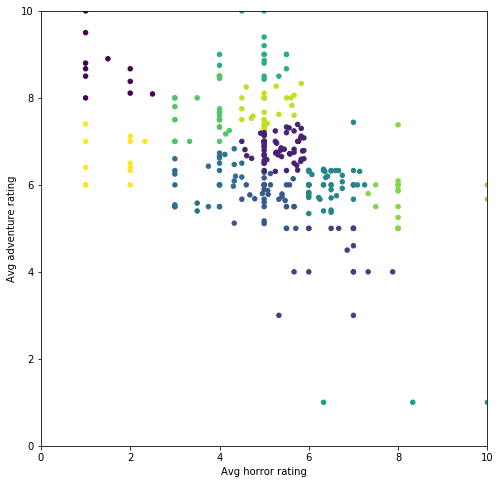

In [43]:
k_means = KMeans(n_clusters=12)

predictions = k_means.fit_predict(X)

draw_clusters(biased_dataset, predictions)

Ajout de tous les différents genres, clustering haut niveau

In [44]:
ratings_title = pd.merge(df_ratings, df_movies[['movie_id', 'title']], on='movie_id' )
user_movie_ratings = pd.pivot_table(ratings_title, index='user_id', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (28979, 25500) 

Subset example:


title,$ (1971),$50K and a Call Girl: A Love Story (2014),$ellebrity (2012),'71 (2014),'A' gai wak (1983),'A' gai wak 2 (1987),'Breaker' Morant (1980),'Crocodile' Dundee II (1988),'Doc' (1971),'Hukkunud Alpinisti' hotell (1979)
user_id,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
def get_most_rated_movies(user_movie_ratings, n_movies):
    movies_names = user_movie_ratings.count().sort_values(ascending=False)[:n_movies].index.tolist()
    most_rated_movies = user_movie_ratings[movies_names]
    return most_rated_movies

In [68]:
def get_users_who_rate_the_most(user_movie_ratings, n_users):
    user_ids = user_movie_ratings.count(axis=1).sort_values(ascending=False)[:n_users].index.tolist()
    most_rated_movies = user_movie_ratings.loc[user_ids]
    return most_rated_movies

In [69]:
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title,Gravity (2013),Interstellar (2014),The Wolf of Wall Street (2013),Man of Steel (2013),Joker (2019),Now You See Me (2013),World War Z (2013),Iron Man 3 (2013),Gone Girl (2014),Prisoners (2013),...,Her (2013),X-Men: Days of Future Past (2014),Oblivion (2013),The Grand Budapest Hotel (2014),Batman v Superman: Dawn of Justice (2016),Captain America: The Winter Soldier (2014),Whiplash (2014),Rush (2013),Arrival (2016),Hacksaw Ridge (2016)
user_id,,,,,,,,,,,,,,,,,,,,,
11896,8.0,9.0,8.0,8.0,6.0,6.0,8.0,7.0,7.0,8.0,...,10.0,9.0,7.0,9.0,5.0,NaN,7.0,10.0,9.0,8.0
24592,8.0,9.0,9.0,7.0,9.0,5.0,5.0,5.0,9.0,9.0,...,9.0,7.0,9.0,8.0,5.0,7.0,9.0,8.0,8.0,8.0
7228,10.0,9.0,8.0,4.0,10.0,8.0,7.0,7.0,7.0,8.0,...,7.0,8.0,6.0,8.0,6.0,NaN,8.0,10.0,9.0,10.0
8934,10.0,8.0,7.0,7.0,NaN,NaN,8.0,7.0,8.0,8.0,...,10.0,5.0,7.0,6.0,5.0,8.0,9.0,7.0,8.0,NaN
24662,10.0,NaN,8.0,1.0,NaN,10.0,10.0,10.0,10.0,10.0,...,4.0,10.0,10.0,10.0,10.0,10.0,8.0,6.0,NaN,NaN


Visualisation de nombreuses dimensions par *heatmap*

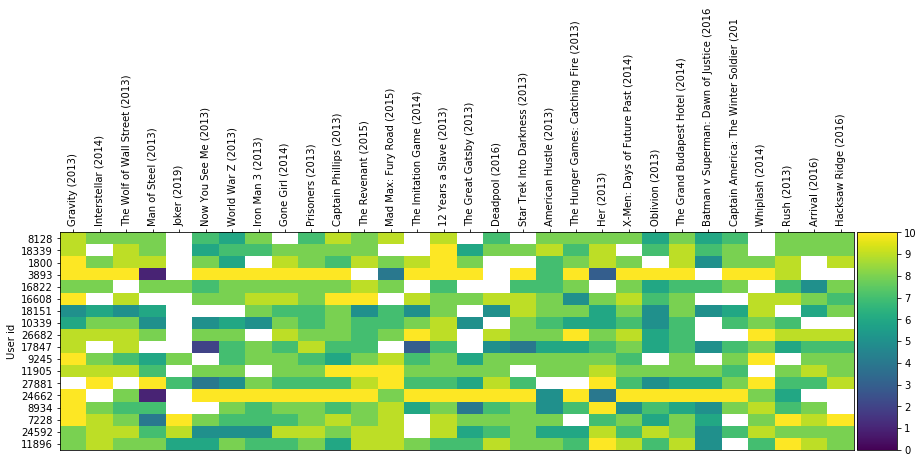

In [70]:

def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    """
    Helper heatmap plotting function
    """
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=10, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')
    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # Color bar
    cbar = fig.colorbar(heatmap, ticks=range(0,11), cax=cax)
    # cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    
plt.show()
# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [71]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='user_id', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [72]:
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

C:\Users\Lenovo\Anaconda3\envs\reco\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  """Entry point for launching an IPython kernel.
C:\Users\Lenovo\Anaconda3\envs\reco\lib\site-packages\pandas\core\frame.py:3471: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)


In [85]:
def draw_movie_clusters(clustered, max_users, max_movies):
    
    # Print 3 clusters for debugging purpose
    n_clusters = 3
    
    total_clusters = clustered.group.max()
    cluster_numbers = np.random.permutation(total_clusters)[:n_clusters]
    
    for cluster_number in cluster_numbers:
        cluster = clustered[clustered.group == cluster_number].drop(['user_id', 'group'], axis=1)
        n_users_cluster = cluster.shape[0]
        
        cluster = sort_by_rating_density(cluster, max_movies, max_users)
        n_users_plot = cluster.shape[0]
        
        print(f'cluster #{cluster_number} \n #users in cluster : {n_users_cluster}. #users in plot : {n_users_plot}')
        draw_movies_heatmap(cluster, axis_labels=True)
        plt.show()
    

In [74]:
# KMeans appliqué pour 22 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)
# Select the max number of users and movies heatmap cluster
max_users = 70
max_movies = 50
# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

NameError: name 'draw_movie_clusters' is not defined

cluster #11 
 #users in cluster : 1. #users in plot : 1


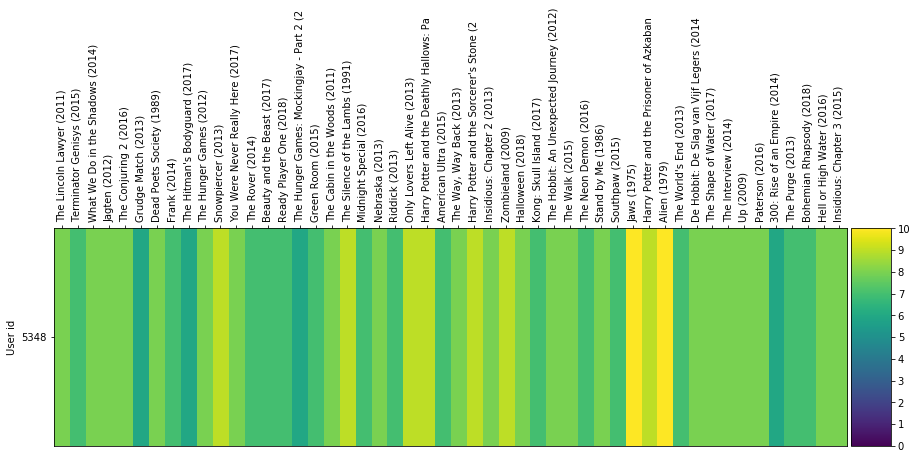

cluster #19 
 #users in cluster : 7. #users in plot : 7


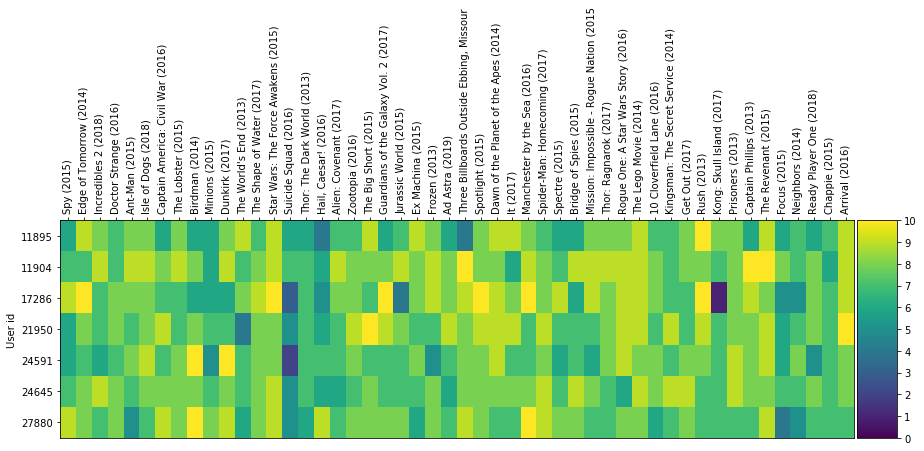

cluster #7 
 #users in cluster : 232. #users in plot : 70


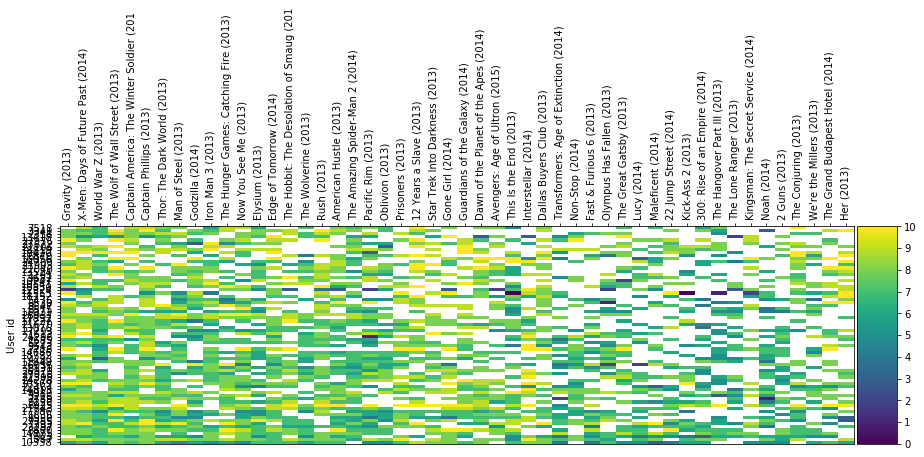

In [86]:
draw_movie_clusters(clustered, max_users, max_movies)

Observations :
+ Les lignes verticales unicolores représentent une similarité dans les notes pour ce film
+ Certains clusters sont plus dispersés que d'autres, l'algorithme va donc grouper les gens qui notent moins de films également
+ Les clusters ont souvent une couleur dominante (Jaune si ils ont aimé les films, bleu sinon)
+ Les lignes horizontales unicolores représentent des utilisateurs notant tous les films de la même facon

Prédiction des notes et évaluation de l'algorithme

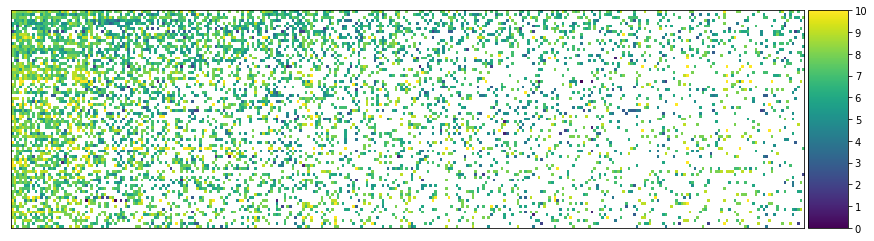

In [88]:
# Pick a cluster ID from the clusters above
cluster_number = 7
# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['user_id', 'group'], axis=1)
# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [89]:
cluster.fillna('').head()

,Gravity (2013),X-Men: Days of Future Past (2014),World War Z (2013),The Wolf of Wall Street (2013),Captain America: The Winter Soldier (2014),Captain Phillips (2013),Thor: The Dark World (2013),Man of Steel (2013),Godzilla (2014),Iron Man 3 (2013),...,Insurgent (2015),Everest (2015),Killing Them Softly (2012),Zootopia (2016),Project Almanac (2014),Paranormal Activity: The Marked Ones (2014),The Big Wedding (2013),The Babadook (2014),10 Cloverfield Lane (2016),Pitch Perfect 2 (2015)
1887,9,9,8,8,8,8,9,9,8,8,...,7,9,,,7,8,,7,,
8550,8,8,7,7,6,7,7,5,5,,...,,,4,,6,,,,,
14871,8,8,7,8,8,8,,7,,8,...,,8,6,,7,,6,6,,8
923,,6,7,7,6,8,6,6,5,8,...,,,,8,,,,,5,
10338,6,7,6,8,7,8,6,5,6,5,...,,,4,,,,,,,


Pour prédire une note, on fait l'hypothèse que les utilisateurs étant regroupés par clusters, ont des goûts similaires et donc vont donner une note d'envirion la moyenne de celle des autres utilisateurs

In [90]:
# Les utilisateurs de ce cluster n'ayant pas vu Zootopia auraient tendance à le noter 7.1/10 en moyenne
cluster['Zootopia (2016)'].mean()

7.111111111111111

Recommendations

In [131]:
def recommend(user_id, clustered, topn=20):
    
    # Retrieve the user's cluster
    cluster_number = clustered.loc[user_id].group
    cluster = clustered[clustered.group == cluster_number].drop(['user_id', 'group'], axis=1) 
    
    print('Cluster n°', cluster_number)
    
    
    # Get all this user's ratings
    user_2_ratings  = cluster.loc[user_id, :]
    
    # Which movies did they not rate? 
    user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
    
    # What are the ratings of these movies the user did not rate?
    avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
    
    # Let's sort by rating so the highest rated movies are presented first
    print(f'TOP {topn} recommendations for user {user_id} : ')
    return avg_ratings.sort_values(ascending=False)[:topn]

In [132]:
recs = recommend(11895, clustered)
recs

Cluster n° 19.0
TOP 20 recommendations for user 11895 : 


The Godfather: Part II (1974)      10.000000
Inception (2010)                   10.000000
Raiders of the Lost Ark (1981)     10.000000
Into the Wild (2007)               10.000000
Saving Private Ryan (1998)         10.000000
Monsters, Inc. (2001)              10.000000
Salinui chueok (2003)              10.000000
Up (2009)                          10.000000
Forrest Gump (1994)                10.000000
Schindler's List (1993)             9.500000
The Green Mile (1999)               9.500000
The Godfather (1972)                9.500000
The Pianist (2002)                  9.500000
Full Metal Jacket (1987)            9.500000
The Game (1997)                     9.500000
The Shawshank Redemption (1994)     9.500000
Little Miss Sunshine (2006)         9.500000
WALLÂ·E (2008)                      9.250000
Inside Out (2015)                   9.166667
Avengers: Endgame (2019)            9.166667
Name: 0, dtype: float64

In [133]:
recs = recommend(11904, clustered)
recs

Cluster n° 19.0
TOP 20 recommendations for user 11904 : 


Monsters, Inc. (2001)                                   10.0
Inception (2010)                                        10.0
Apocalypse Now (1979)                                   10.0
Children of Men (2006)                                  10.0
Incendies (2010)                                        10.0
The Lord of the Rings: The Return of the King (2003)    10.0
Jaws (1975)                                             10.0
Saving Private Ryan (1998)                              10.0
Salinui chueok (2003)                                   10.0
Forrest Gump (1994)                                     10.0
Raiders of the Lost Ark (1981)                          10.0
Silver Linings Playbook (2012)                          10.0
Up (2009)                                               10.0
Taxi Driver (1976)                                      10.0
The Godfather: Part II (1974)                           10.0
Alien (1979)                                             9.5
Full Metal Jacket (1987)

Cette méthode pose plusieurs problèmes :
+ Prendre la moyenne pour notes peut propulser un film en haut des recommendations car une seule personne l'a très bien noté
+ On s'intéresse ici qu'aux 1000 films les plus notés, il faudrait étudier les performances en considérant l'ensemble des films
+ Afin de choisir le bon nombre de clusters, il faudrait réitérer la méthode *Elbow* de manière réccurente afin de recalculer les clusters en prenant en compte les nouveaux utilisateurs/films
+ On n'utilise ici l'algorithme KMeans pour trouver les clusters, on pourrait regarder comment se comporte l'algorithme CAH (classification ascendante hiérarchique)

## Références
+ Notebook superbement détaillé sur la recommendation de livres par LDA : https://humboldt-wi.github.io/blog/research/information_systems_1819/is_lda_final/